In [2]:
# Step 1: Install dependencies
!pip install -q tensorflow tensorflow-datasets matplotlib

In [17]:
# Step 2: Import libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import time
from IPython.display import clear_output

# Step 3: Load the dataset (oxford_iiit_pet)
!rm -rf ~/tensorflow_datasets/oxford_iiit_pet/4.0.0

dataset, info = tfds.load(
    'oxford_iiit_pet:4.0.0',
    with_info=True,
    as_supervised=False
)




Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.KVCB3I_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.KVCB3I_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [18]:

# Step 4: Preprocessing
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32)
    input_mask -= 1.0  # pet dataset uses labels {1, 2, 3}, so we subtract 1 -> {0, 1, 2}
    return input_image, input_mask

def load_image(datapoint):
    # Resize image
    image = tf.image.resize(datapoint['image'], (256, 256))

    # Resize mask and ensure it's shaped [256, 256, 1]
    mask = tf.image.resize(datapoint['segmentation_mask'], (256, 256), method='nearest')
    if tf.rank(mask) == 2:
        mask = tf.expand_dims(mask, axis=-1)

    # Set known shapes
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])

    image, mask = normalize(image, mask)
    return image, mask

# Build the dataset pipeline
train = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(1000).batch(1)

In [19]:
# Step 5: Generator (U-Net)
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()


In [20]:
# Step 6: Discriminator (PatchGAN)
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()


In [21]:
# Step 7: Loss and Optimizers
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Initialize optimizers by applying gradients with dummy variables
dummy_vars = [tf.Variable(tf.zeros_like(v)) for v in generator.trainable_variables]
generator_optimizer.apply_gradients(zip(dummy_vars, generator.trainable_variables))
dummy_vars = [tf.Variable(tf.zeros_like(v)) for v in discriminator.trainable_variables]
discriminator_optimizer.apply_gradients(zip(dummy_vars, discriminator.trainable_variables))

<Variable path=adam/iteration, shape=(), dtype=int64, value=1>

In [22]:
# Step 8: Training Loop
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


In [24]:
@tf.function
def train_step(input_image, target):
    # Convert 1-channel mask to 3 channels
    target_rgb = tf.tile(target, [1, 1, 1, 3])  # [batch, 256, 256, 1] → [batch, 256, 256, 3]

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target_rgb], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target_rgb)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


In [25]:
# Step 9: Training
EPOCHS = 5

for epoch in range(EPOCHS):
    print("Epoch", epoch + 1)
    for input_image, target in train.take(100):
        train_step(input_image, target)


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


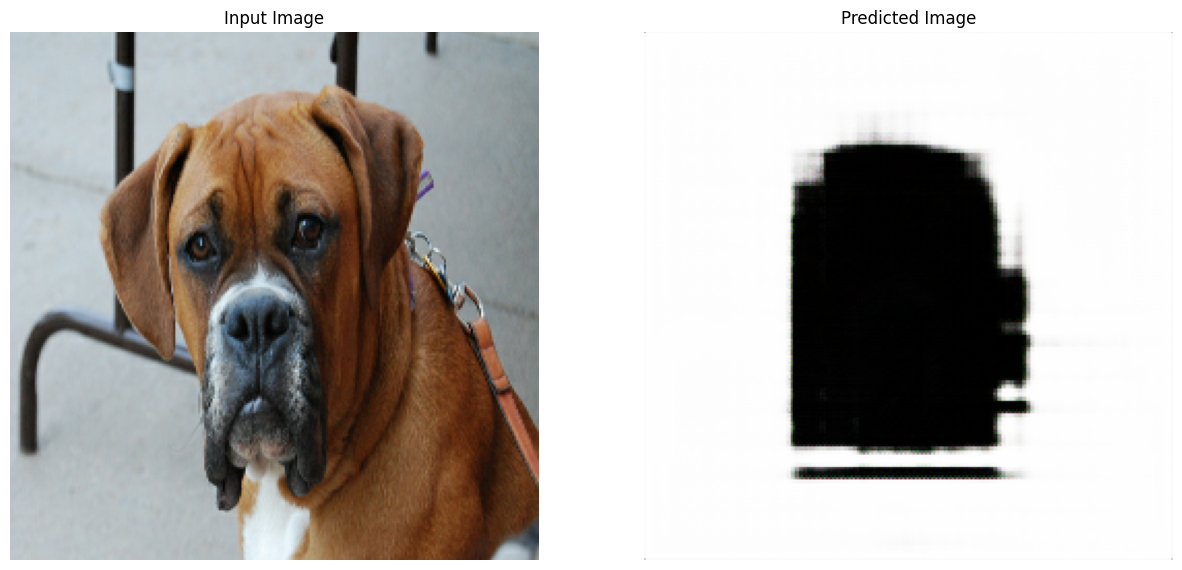

In [26]:
# Step 10: Visualize result
def generate_images(model, test_input):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

# Test on a batch
for example_input, example_target in train.take(1):
    generate_images(generator, example_input)

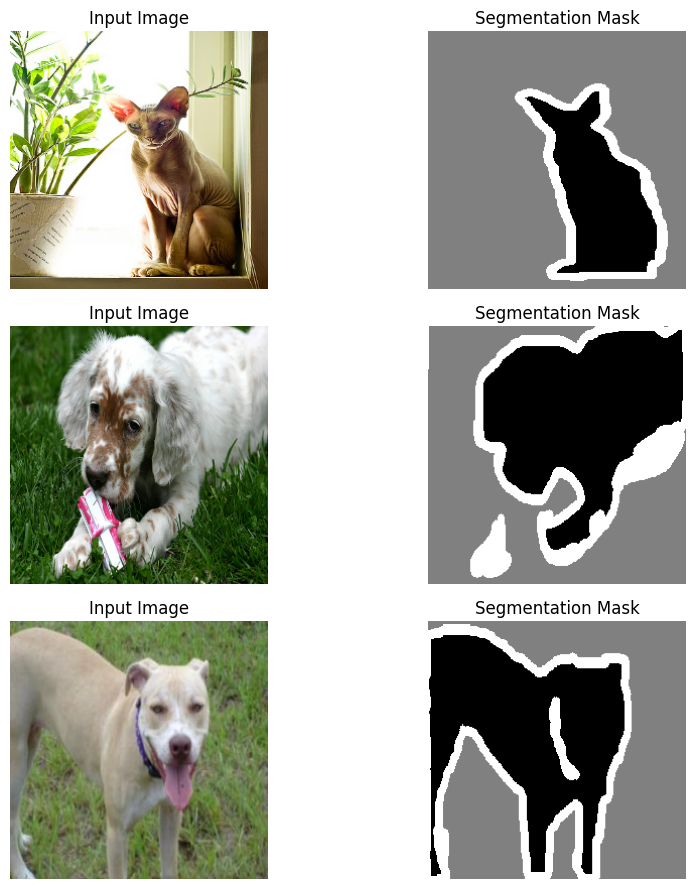

In [32]:
# Step 4.1: Visualize Sample Images and Masks from the Training Set
def display_sample(dataset, num=3):
    plt.figure(figsize=(10, num * 3))
    for i, (image, mask) in enumerate(dataset.take(num)):
        plt.subplot(num, 2, 2 * i + 1)
        plt.title("Input Image")
        plt.imshow(image[0])
        plt.axis("off")

        plt.subplot(num, 2, 2 * i + 2)
        plt.title("Segmentation Mask")
        plt.imshow(mask[0, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show samples
display_sample(train, num=3)


In [33]:
import os

path = "/content/drive/MyDrive/Colab Notebooks/pix2pix_colab.ipynb"
print(os.path.exists(path))  # True if file exists


True


In [35]:
import nbformat

notebook_path = "/content/drive/MyDrive/Colab Notebooks/pix2pix_colab.ipynb"

# Load notebook
nb = nbformat.read(notebook_path, as_version=4)

# Remove bad widget metadata if it exists
if "widgets" in nb.metadata:
    print("🔧 Cleaning metadata.widgets...")
    del nb.metadata["widgets"]
else:
    print("✅ No widget metadata to fix.")

# Save cleaned notebook
nbformat.write(nb, notebook_path)
print("✅ Notebook cleaned and saved.")


✅ No widget metadata to fix.
✅ Notebook cleaned and saved.


In [36]:
from google.colab import userdata
GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')

In [37]:
import base64
import requests
from google.colab import userdata

GITHUB_USERNAME = "Rajratna25"
REPO_NAME = "pix2pix-cGAN"
GITHUB_FILE_PATH = "pix2pix_colab.ipynb"
LOCAL_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/pix2pix_colab.ipynb"
COMMIT_MESSAGE = "Upload cleaned notebook securely"
GITHUB_TOKEN = userdata.get("GITHUB_TOKEN")  # Securely retrieved

# Encode file content
with open(LOCAL_FILE_PATH, "rb") as f:
    content = base64.b64encode(f.read()).decode()

# Check if file exists (to get SHA)
url = f"https://api.github.com/repos/{GITHUB_USERNAME}/{REPO_NAME}/contents/{GITHUB_FILE_PATH}"
headers = {"Authorization": f"token {GITHUB_TOKEN}"}
res = requests.get(url, headers=headers)
sha = res.json().get("sha") if res.status_code == 200 else None

# Prepare upload data
data = {
    "message": COMMIT_MESSAGE,
    "content": content,
    "branch": "main"
}
if sha:
    data["sha"] = sha  # Required if updating existing file

# Upload
upload_res = requests.put(url, headers=headers, json=data)

# Output
if upload_res.status_code in [200, 201]:
    print(f"✅ Uploaded to GitHub: https://github.com/{GITHUB_USERNAME}/{REPO_NAME}/blob/main/{GITHUB_FILE_PATH}")
else:
    print("❌ Upload failed:", upload_res.json())


✅ Uploaded to GitHub: https://github.com/Rajratna25/pix2pix-cGAN/blob/main/pix2pix_colab.ipynb
